## In this notebook, we explore the relationships among theta band LFP, ripple band LFP and speed

In [2]:
%reload_ext autoreload
%autoreload 2

In [401]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)

from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,TrialChoiceRemoteReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,find_remote_times,mua_thresholder,
                                   segment_ripples,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,plot_decode_spiking,
                                            load_decode,load_position,load_theta,load_ripple
                                  )
from ripple_detection.core import get_envelope
from spyglass.shijiegu.helpers import interpolate_to_new_time

import warnings
warnings.filterwarnings('ignore')

In [387]:
# the only cell to be edited
nwb_file_name = 'eliot20221024.nwb'
#epoch_num=4

In [388]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward pandas dataframe, choice"
eliot20221024_.nwb,2,02_Seq2Session2,=BLOB=
eliot20221024_.nwb,4,04_Seq2Session3,=BLOB=
eliot20221024_.nwb,6,06_Seq2Session4,=BLOB=
eliot20221024_.nwb,8,08_Seq2Session5,=BLOB=
eliot20221024_.nwb,10,10_Seq2Session6,=BLOB=


In [389]:
IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name}

position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,analysis_file_name name of the file,head_position_object_id,head_orientation_object_id,head_velocity_object_id
default,eliot20221024_.nwb,pos 1 valid times,eliot20221024_LF7XXXC7WS.nwb,5f4c05bc-09e0-4af6-b9ce-1853c0378933,39f34be9-87dd-40f7-8985-575158974af1,fee7cfb9-5f42-46a0-be2c-6ba72482b9b8
default,eliot20221024_.nwb,pos 3 valid times,eliot20221024_CQHVC8W9YO.nwb,6e0ac1ac-4fc1-4454-8a8a-2ab73c36ac4c,a67d7101-6868-4adc-883f-e4499facee3f,93f580d5-7a23-4b2e-933d-da3b06dbc9f3
default,eliot20221024_.nwb,pos 5 valid times,eliot20221024_B15OP7T247.nwb,1acfaea2-f173-483a-989b-3aa16ce781fe,27502dd2-8df0-4a85-978a-6b297055bdf0,d361dba4-eae6-4936-900b-acf5ef81f934
default,eliot20221024_.nwb,pos 7 valid times,eliot20221024_BAM28O6YJQ.nwb,9557c422-1266-4572-a55d-9fb6de1252eb,b8a6438e-b562-4aea-98b3-36cc32f1e925,4ae7523f-5241-4c12-b6ad-35e6b65ea3a5
default,eliot20221024_.nwb,pos 9 valid times,eliot20221024_M4OYYYOYFK.nwb,3374d1ac-491d-42c8-b7e0-f62244ab137c,ea254f5f-6543-458f-8fec-de56cc764d11,0c18d0d5-8882-45db-b3c4-23da3fccf7e1
default_decoding,eliot20221024_.nwb,pos 1 valid times,eliot20221024_4V68CJ354Y.nwb,0e5e9085-d03e-4717-94a9-01b85e6612fb,e1a81f59-5bd9-4ea1-9ce3-5f52fd78154a,cd26f0d1-1979-4097-b4c5-a5ba9a92b284
default_decoding,eliot20221024_.nwb,pos 3 valid times,eliot20221024_JLWSZX0624.nwb,e6e0f5fa-2afa-4f2f-9a5e-a8d25126fa66,31b0512e-1c20-400a-8b5f-4363ecea5a20,a0b7b6cd-6997-4e37-b068-a06fc6f8bb8b
default_decoding,eliot20221024_.nwb,pos 5 valid times,eliot20221024_F4HREIXIXV.nwb,9720500c-aca3-475c-840b-42a4b8ab7a06,fd94b2f0-d64a-4ff0-af16-b1aa43653e06,b2774973-c1ca-4306-ac1a-4836af7ceb13
default_decoding,eliot20221024_.nwb,pos 7 valid times,eliot20221024_SQOPQJWA0K.nwb,37243f1c-8494-47a8-ad2f-6f67d5f9b935,81110d59-917d-4e02-838a-33ac35f98b23,bcf34ace-64a7-4caa-a2cd-77ddd14160b0
default_decoding,eliot20221024_.nwb,pos 9 valid times,eliot20221024_VV4225334V.nwb,540c2f23-6394-4ea7-87ad-9d123cfc295a,a3bba802-fd1c-4e60-87a9-31f176cbe65e,45b25961-d6e0-4319-aa57-f6432d7888cf


In [394]:
epoch_num=2

# Load state script
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
log=(TrialChoice & key).fetch1('choice_reward')
epoch_name=(TrialChoice & key).fetch1('epoch_name')
epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
print('epoch name',epoch_name)
print('epoch_pos_name',epoch_pos_name)
log_df=pd.DataFrame(log)


epoch name 02_Seq2Session2
epoch_pos_name pos 1 valid times


In [399]:
# load decode
decode=load_decode(nwb_copy_file_name,epoch_name)

# load position
position_info=load_position(nwb_copy_file_name,epoch_pos_name)

head_speed=pd.DataFrame(position_info['head_speed'])
head_orientation=pd.DataFrame(position_info['head_orientation'])

In [402]:
# load_theta
theta_data,theta_timestamps=load_theta(nwb_copy_file_name,epoch_name)

# load_ripple
ripple_data,ripple_timestamps=load_ripple(nwb_copy_file_name,epoch_name)

8


Text(0.5, 1.0, 'animal head angular speed')

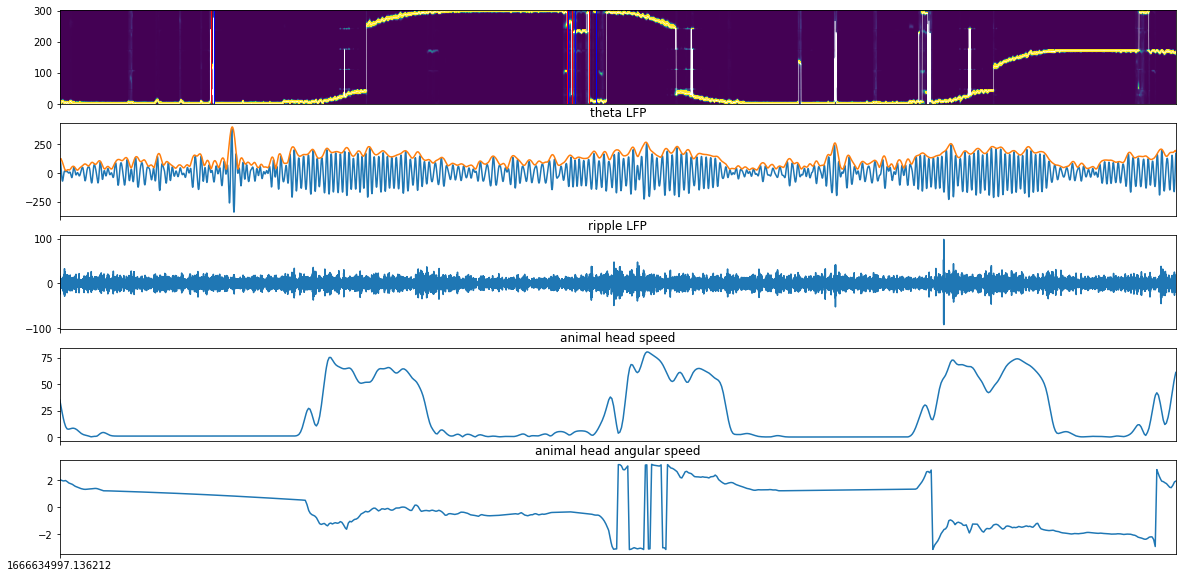

In [447]:
t=8
print(t)

t0=df.loc[t,'timestamp_O']-10
t1=df.loc[t,'timestamp_O']+20
h=headspeed_lfp_xr.sel(time=slice(t0,t1))
close_ind=np.abs(linear_position_xr.sel(time=slice(t0,t1)).linear_position-current_location)<10

mask_time = ((decode.time >= t0) & (decode.time < t1))
acausal_posterior=decode.isel(time=mask_time).acausal_posterior
time=np.array(acausal_posterior.time)
mean_location=np.matmul(np.array(acausal_posterior.sum(dim='state')),np.arange(acausal_posterior.position.size))
max_location=acausal_posterior.sum(dim='state').argmax(dim='position')
    
f,axes=plt.subplots(nrows=5,ncols=1,figsize=(20,10),sharex=True)

'''decode'''
x_axis=np.arange(time[0],time[-1],100)
axes[0].imshow(acausal_posterior.sum(dim='state').T,extent=(time[0],time[-1],0,301),vmax=0.02,origin='lower')
axes[0].set_xticks(x_axis, x_axis)
axes[0].set_aspect('auto')

#axes.plot(mean_location,color='red',alpha=0.2)

axes[0].plot(time,max_location,color='white',alpha=1,linewidth=0.5)
#axes[1].plot(np.array(h.time),close_ind*10)

remote_H=df.loc[t,'remote_H']
remote_O=df.loc[t,'remote_O']
if len(remote_H)>0 and len(remote_O)>0:
    remote_times=np.concatenate((remote_H,remote_O))
if len(remote_times)>0:
    for r in remote_times:
        axes[0].axvline(r[0],color='r',linewidth=1)
        axes[0].axvline(r[-1],color='b',linewidth=1)

'''theta'''
t_ind = np.argwhere(np.logical_and(theta_timestamps >= t0,
                                   theta_timestamps < t1)).ravel()
theta_d = theta_data[t_ind,:].astype('int32')
theta_t = theta_timestamps[t_ind]


#for e in range(0,np.shape(theta_d)[1],10):
#    axes[1].plot(theta_t,theta_d[:,e])
axes[1].plot(theta_t,np.mean(theta_d,axis=1))
axes[1].plot(theta_t,np.mean(get_envelope(theta_d),axis=1))
axes[1].set_title('theta LFP')

'''ripple'''
t_ind = np.argwhere(np.logical_and(ripple_timestamps >= t0,
                                   ripple_timestamps < t1)).ravel()
ripple_d = ripple_data[t_ind,:].astype('int32')
ripple_t = ripple_timestamps[t_ind]

axes[2].plot(ripple_t,np.mean(ripple_d,axis=1))
axes[2].set_title('ripple LFP')

'''speed information'''
head_speed_lfp = interpolate_to_new_time(head_speed, theta_timestamps)
headspeed_lfp_xr=xr.Dataset.from_dataframe(head_speed_lfp)
h=headspeed_lfp_xr.sel(time=slice(t0,t1))

axes[3].plot(np.array(h.time),np.array(h.head_speed))
axes[3].set_title('animal head speed')

head_orientation_lfp = interpolate_to_new_time(head_orientation, theta_timestamps)
head_orientation_lfp_xr=xr.Dataset.from_dataframe(head_orientation_lfp)
phi=head_orientation_lfp_xr.sel(time=slice(t0,t1))
phi=phi.diff("head_orientation")

axes[4].plot(np.array(phi.time),np.array(phi.head_orientation))
axes[4].set_title('animal head angular speed')


### Distribution of Theta and Ripple Band Power

In [430]:
ripple_power=np.abs(np.mean(ripple_d,axis=1))
theta_power=np.abs(np.mean(theta_d,axis=1))

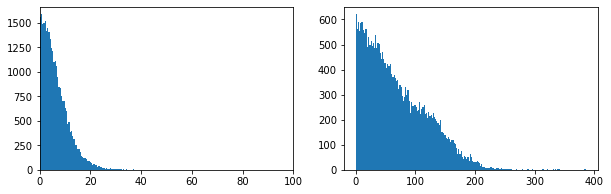

In [433]:
f,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,3));
axes[0].hist(ripple_power,bins=200);
axes[0].set_xlim([0,100])

axes[1].hist(theta_power,bins=200);
#axes[1].set_xlim([0,2000])

### Look into the relationship between Theta and speed

Text(0.5, 0, '1D head speed')

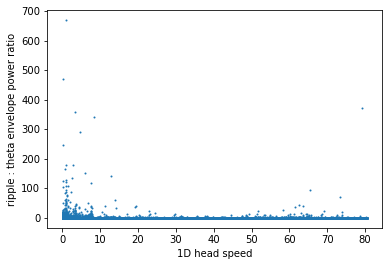

In [445]:
plt.scatter(np.array(h.head_speed),ripple_power/(theta_power),s=1)
plt.ylabel('ripple : theta envelope power ratio')
plt.xlabel('1D head speed')

Text(0, 0.5, 'theta envelope power')

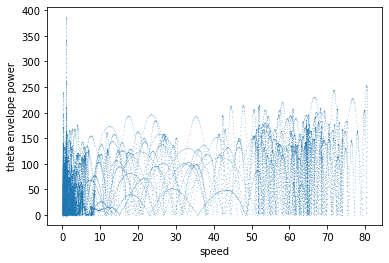

In [446]:
plt.scatter(np.array(h.head_speed),theta_power,s=0.01)
plt.xlabel('speed')
plt.ylabel('theta envelope power')

Text(0, 0.5, 'ripple envelope power')

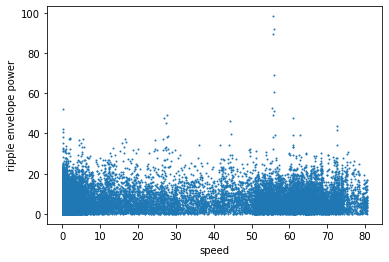

In [438]:
plt.scatter(np.array(h.head_speed),ripple_power,s=1)
plt.xlabel('speed')
plt.ylabel('ripple envelope power')

Text(0.5, 0.5, 'theta envelope power')

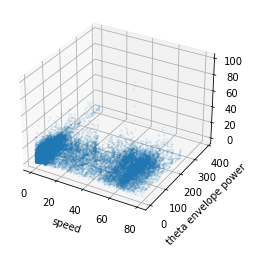

In [443]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.array(h.head_speed),
           theta_power,ripple_power,s=1,alpha=0.1)
plt.xlabel('speed')
plt.ylabel('theta envelope power')